In [39]:
import numpy as np
import pandas as pd
from tifffile import imread, imsave
import matplotlib.pyplot as plt
import glob
from scipy import ndimage as ndi
from skimage.filters import gaussian
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from math import cos, sin, pi
from scipy.interpolate import interp1d
from scipy.spatial import Delaunay
from skimage.morphology import dilation, watershed, disk
%matplotlib inline
from scipy.ndimage.interpolation import rotate
from scipy.interpolate import interp1d
import sys
import matplotlib.patches as patches
from pysal.explore.pointpats import PointPattern, PoissonPointProcess, as_window, G, F, J, K, L, Genv, Fenv, Jenv, Kenv, Lenv
sys.path.append('lib')
from segment import *
from scipy import fftpack
from skimage.feature import peak_local_max
from skimage.feature import greycomatrix, greycoprops
from matplotlib.patches import Rectangle
from skimage import measure
from skimage.measure import perimeter
from matplotlib.patches import Patch
from scipy.stats import linregress, ttest_ind


In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
plt.rcParams['font.size']=12
px_size=(10/900,10/900,2.18/1000)
filt_size=15
plexi=20

prep stack

In [25]:
l_files=glob.glob('../..') #path to DEMs (from ImageProcessing notebook)
l_files.sort()
l_files

['../OCT-final_images/20200502_HighRes_final_images/20181208_time0_B5_ZMap20200502.tif',
 '../OCT-final_images/20200502_HighRes_final_images/20181211_time1_B5_ZMap20200502.tif',
 '../OCT-final_images/20200502_HighRes_final_images/20181214_time2_B5_ZMap20200502.tif',
 '../OCT-final_images/20200502_HighRes_final_images/20181217_time3_B5_ZMap20200502.tif',
 '../OCT-final_images/20200502_HighRes_final_images/20181220_time4_B5_ZMap20200502.tif',
 '../OCT-final_images/20200502_HighRes_final_images/20181223_time5_B5_ZMap20200502.tif',
 '../OCT-final_images/20200502_HighRes_final_images/20181227_time7_B5_ZMap20200502.tif',
 '../OCT-final_images/20200502_HighRes_final_images/20181228_time0_B5_ZMap20200502.tif',
 '../OCT-final_images/20200502_HighRes_final_images/20181231_time1_B5_ZMap20200502.tif',
 '../OCT-final_images/20200502_HighRes_final_images/20190103_time2_B5_ZMap20200502.tif',
 '../OCT-final_images/20200502_HighRes_final_images/20190106_time3_B5_ZMap20200502.tif',
 '../OCT-final_images

In [24]:
#compose one stack for each timeseries
# images=[]
# for path in l_files[:6]:
#     i=imread(path)
#     i=ndi.median_filter(i, size=filt_size)
#     i=i-plexi
#     i[i<0]=0
#     i=i[10:2110,10:2110]
#     images.append(i)
#     imsave(path[:-4]+'_smooth.tif',i)
# st=np.stack(images)
# imsave('Stack.tif', st)

['..\\..\\..\\sber\\non_backup\\Anna\\201812-1901_experiment\\20200502_HighRes_final_images\\20181208_time0_B3_ZMap20200502_new.tif',
 '..\\..\\..\\sber\\non_backup\\Anna\\201812-1901_experiment\\20200502_HighRes_final_images\\20181211_time1_B3_ZMap20200502_new.tif',
 '..\\..\\..\\sber\\non_backup\\Anna\\201812-1901_experiment\\20200502_HighRes_final_images\\20181214_time2_B3_ZMap20200502_new.tif',
 '..\\..\\..\\sber\\non_backup\\Anna\\201812-1901_experiment\\20200502_HighRes_final_images\\20181217_time3_B3_ZMap20200502_new.tif',
 '..\\..\\..\\sber\\non_backup\\Anna\\201812-1901_experiment\\20200502_HighRes_final_images\\20181220_time4_B3_ZMap20200502_new.tif',
 '..\\..\\..\\sber\\non_backup\\Anna\\201812-1901_experiment\\20200502_HighRes_final_images\\20181223_time5_B3_ZMap20200502_new.tif']

In [7]:
#segmentation function to separate base biofilm (=1, "carpet"), troughs (=0, "valleys") and clusters (=2, "mounds")
def valleys(i):
    gau=ndi.gaussian_filter(i,sigma=300)
    norm=(i/gau)
    m=np.zeros(norm.shape)
    m[norm>.5]=1
    m[norm>3]=2
    return m

#function to extract morphological parameters from each stack
def temp_dynamics(st):
    vol=np.sum(st,axis=(1,2))
    q01=np.quantile(st,.1,axis=(1,2))
    q09=np.quantile(st,.9,axis=(1,2))
    med=np.median(st,axis=(1,2))
    
    cov=np.sum(st>0,axis=(1,2))/(st.shape[1]*st.shape[2])
    diff=np.diff(vol)
    ratio=vol[1:]/vol[:-1]
    hei=np.quantile(st,.99,axis=(1,2))
    hei2=np.quantile(st,.95,axis=(1,2))
    v=np.stack([valleys(st[t,:,:]) for t in range(st.shape[0])])
    mounds=np.sum(v==2,axis=(1,2))/(v.shape[1]*v.shape[2])
    carpet=np.sum(v==1,axis=(1,2))/(v.shape[1]*v.shape[2])
    vall=np.sum(v==0,axis=(1,2))/(v.shape[1]*v.shape[2])
    st1=st.copy();st1[v!=2]=0
    mound_vol=np.sum(st1,axis=(1,2))/vol
    st1=st.copy();st1[v!=1]=0
    carpet_vol=np.sum(st1,axis=(1,2))/vol
    gr=st[1:,:,:]/st[:-1,:,:]
    gr[gr==np.inf]=1000
    gq01=np.quantile(gr,.1,axis=(1,2))
    gq09=np.quantile(gr,.9,axis=(1,2))
    gmed=np.median(gr,axis=(1,2))

    grb=np.diff(st,axis=0);grb[gr>0]=0;
    neg_growth=np.sum(grb,axis=(1,2))
    newv=np.logical_and(v[1:]==0,v[:-1,:,:]!=0)
    newm=np.logical_and(v[1:]==2,v[:-1,:,:]!=2)
    newc=np.logical_and(v[1:]==1,v[:-1,:,:]!=1)
    
    ngr=gr<1
    egr=gr>3
    empty=st[1:]==0
    
    neg_growth_bottom=np.sum(np.logical_and(ngr,empty),axis=(1,2))/np.sum(ngr,axis=(1,2))
    neg_growth_vall=np.sum(np.logical_and(newv,ngr),axis=(1,2))/np.sum(newv,axis=(1,2))
    neg_growth_carpet=np.sum(np.logical_and(newc,ngr),axis=(1,2))/np.sum(newc,axis=(1,2))
    neg_growth_mound=np.sum(np.logical_and(newm,ngr),axis=(1,2))/np.sum(newm,axis=(1,2))
    
    extra_growth_vall=np.sum(np.logical_and(newv,egr),axis=(1,2))/np.sum(newv,axis=(1,2))
    extra_growth_carpet=np.sum(np.logical_and(newc,egr),axis=(1,2))/np.sum(newc,axis=(1,2))
    extra_growth_mound=np.sum(np.logical_and(newm,egr),axis=(1,2))/np.sum(newm,axis=(1,2))
 
    autocorr=[];Gr_mound=[];Gr_carpet=[];Gr_valley=[];Hei=[];Gr=[];
    for t in range(st.shape[0]):
        patch=st[t,:,:]
        glcm = greycomatrix(patch, distances=[5], angles=[0], levels=np.max(patch.astype('uint32'))+1,symmetric=True, normed=True)
        autocorr.append(greycoprops(glcm, 'correlation')[0, 0])
        Hei.append(st[t,:,:].ravel())
    for t in range(gr.shape[0]):
        Gr.append(gr[t,:,:].ravel())
    
        s=gr[t,:,:][v[t+1,:,:]==0];s=s[~np.isnan(s)];s=s[s!=1000]
        Gr_valley.append(s)
        s=gr[t,:,:][v[t+1,:,:]==1];s=s[~np.isnan(s)];s=s[s!=1000]
        Gr_carpet.append(s)
        s=gr[t,:,:][v[t+1,:,:]==2];s=s[~np.isnan(s)];s=s[s!=1000]
        Gr_mound.append(s)
    d=pd.DataFrame([list(range(st.shape[0])),vol,diff,ratio,hei,hei2,cov,
                   mounds,carpet,vall,mound_vol,carpet_vol,autocorr,
                   Gr_mound,Gr_valley,Gr_carpet,neg_growth,neg_growth_vall,neg_growth_mound,neg_growth_carpet,
                   extra_growth_vall,extra_growth_mound,extra_growth_carpet,
                   q01,q09,gq01,gq09,med,gmed,Gr,Hei,neg_growth_bottom]).T
    d.columns=['time','vol','diff','ratio','hei','hei2','cov',
              'mounds','carpet','vall','mound_vol','carpet_vol','autocorr',
              'Gr_mound','Gr_valley','Gr_carpet','neg_growth','neg_growth_vall','neg_growth_mound','neg_growth_carpet',
                   'extra_growth_vall','extra_growth_mound','extra_growth_carpet',
              'q01','q09','gq01',"gq09",'med','gmed','Gr','Hei','neg_growth_bottom']
    return d

In [11]:
#figure segmentation
b1=imread('../DEMs\\HR_RepII_FFM_Stack.tif')[5,:,:]
b5=imread('../DEMs\\HR_RepII_SFM_Stack.tif')[5,:,:]

In [62]:
v1=valleys(b1)
v5=valleys(b5)

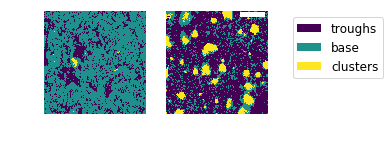

In [103]:
cm=plt.get_cmap('viridis',3)
fig,ax=plt.subplots(ncols=2,figsize=(4,3.5))
ax[0].imshow(v1);ax[0].axis('off')
ax[1].imshow(v5);ax[1].axis('off')

from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=cm(0),label='troughs'),
                  Patch(facecolor=cm(1),label='base'),
                  Patch(facecolor=cm(2),label='clusters')]

ax[1].legend(handles=legend_elements,bbox_to_anchor=[2.2,1])
rect = patches.Rectangle((1600,60),450,10,linewidth=4,edgecolor='white')
ax[1].add_patch(rect)
fig.savefig('../plots-figures/FinalFigures/Fig_morphogenesis/panelB.svg',dpi=300, bbox_inches='tight',transparent=True)

In [10]:
l_files=['../DEMs\\HR_RepII_FFM_Stack.tif',
 '../DEMs\\HR_RepII_SFM_Stack.tif',
 '../DEMs\\HR_RepI_FFM_Stack.tif',
 '../DEMs\\HR_RepI_SFM_Stack.tif']

In [5]:
stacks=[]
for f in l_files:
    stacks.append(imread(f))

In [6]:
st=stacks[0]

In [10]:
neg_growth_coverage=[]
for st in stacks:
    gr=st[6,:,:]-st[5,:,:]
    neg_growth_coverage.append(np.sum(gr<0)*100/(gr.shape[0]*gr.shape[1]))

In [12]:
[round(i,1) for i in neg_growth_coverage]

[28.3, 31.4, 27.1, 39.5]

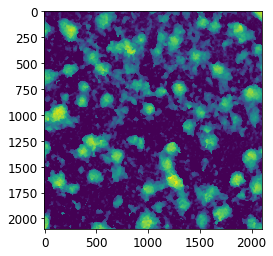

In [16]:
plt.imshow(st[5,:,:])

In [17]:
DF=pd.DataFrame()
for f in l_files:
    st=imread(f)
    d=temp_dynamics(st)
    d['path']=f
    d['rep']=f.split('Rep')[1].split('_')[0]
    d['flow']=f.split('Rep')[1].split('_')[1]
    DF=pd.concat([DF,d],axis=0)

In [18]:
DF.time=DF.time*3
DF['compact']=DF.vol/((st.shape[1]*st.shape[2])*DF.hei)
DF.neg_growth=DF.neg_growth*px_size[0]*px_size[1]*px_size[2]*-1
DF=DF[DF.time!=18]
DF.vol=DF.vol*px_size[0]*px_size[1]*px_size[2]
DF.hei=DF.hei*px_size[2]
DF.hei2=DF.hei2*px_size[2]

In [29]:
#DF.to_csv('../Tables/morphogenesis.csv',index=False)

In [6]:
#DF=pd.read_csv('../Tables/morphogenesis.csv')

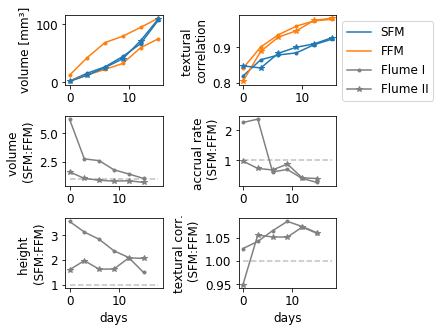

In [28]:
#DIVERGENCE 
var=['vol','diff','hei2','autocorr']
l=['volume \n(SFM:FFM)','accrual rate \n (SFM:FFM)','height \n(SFM:FFM)','textural corr.\n (SFM:FFM)']

fig,ax=plt.subplots(ncols=2,nrows=3,figsize=(6,4.5),constrained_layout=True)
d1=DF[(DF.rep=='I')&(DF.flow=='FFM')]
d2=DF[(DF.rep=='II')&(DF.flow=='FFM')]
d3=DF[(DF.rep=='I')&(DF.flow=='SFM')]
d4=DF[(DF.rep=='II')&(DF.flow=='SFM')]
ax=ax.ravel()
ax[0].plot(d3['time'],d3.vol.values,'.-',color=plt.cm.tab10(1),label='SFM Flume I')
ax[0].plot(d1.time,d1.vol.values,'.-',color=plt.cm.tab10(0),label='FFM Flume I')
ax[0].plot(d4['time'],d4.vol,'.-',color=plt.cm.tab10(1),label='SFM Flume I')
ax[0].plot(d2.time,d2.vol,'*-',color=plt.cm.tab10(0),label='FFM Flume II')

ax[1].plot(d3['time'],d3.autocorr.values,'.-',color=plt.cm.tab10(1),label='SFM Flume I')
ax[1].plot(d1.time,d1.autocorr.values,'.-',color=plt.cm.tab10(0),label='FFM Flume I')
ax[1].plot(d4['time'],d4.autocorr,'*-',color=plt.cm.tab10(1),label='SFM Flume II')
ax[1].plot(d2.time,d2.autocorr,'*-',color=plt.cm.tab10(0),label='FFM Flume II')

ax[0].set_ylabel('volume [mm³]');
ax[1].set_ylabel('textural \ncorrelation');
ax[1].legend(prop={'size': 8},bbox_to_anchor=(.95,.99),
           bbox_transform=plt.gcf().transFigure)
for a in range(len(var)):
#     ax[a].plot(,'.-',color=plt.cm.tab10(0),label='FFM Rep I')
    ax[a+2].plot(d3['time'],d3[var[a]].values/d1[var[a]].values,'.-',color='gray',label='Flume I')
#     ax[a].plot(,'*-',color=plt.cm.tab10(0),label='FFM Rep II')
    ax[a+2].plot(d4['time'],d4[var[a]].values/d2[var[a]].values,'*-',color='gray',label='Flume II')
    ax[a+2].set_ylabel(l[a])
    ax[a+2].hlines(y=1,xmin=0,xmax=18,alpha=.5,color='gray',linestyle='dashed')
ax[-2].set_xlabel('days');
ax[-1].set_xlabel('days');
# ax[3].legend(prop={'size': 8},bbox_to_anchor=(.95,0.7),
#            bbox_transform=plt.gcf().transFigure)

from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color=plt.cm.tab10(0), label='SFM'),
                   Line2D([0], [0], color=plt.cm.tab10(1), label='FFM'),
                   Line2D([0], [0], marker='.', color='gray', label='Flume I'),
                   Line2D([0], [0], marker='*', color='gray', label='Flume II')]

ax[1].legend(handles=legend_elements,bbox_to_anchor=[1,1])

fig.savefig('../plots-figures/FinalFigures/Fig_morphogenesis/panelC.svg',dpi=300, bbox_inches='tight',transparent=True)

In [45]:
d4['diff'].values/d2['diff'].values

array([0.9706832812143106, 0.7245413096561141, 0.6751521143453846,
       0.8718285015371278, 0.4120467679384251, 0.3893995036624647],
      dtype=object)

In [44]:
d3['diff'].values/d1['diff'].values

array([2.25710640637753, 2.3674374932429636, 0.610995686977899,
       0.6896447648314336, 0.3911646592391482, 0.2594657369310718],
      dtype=object)

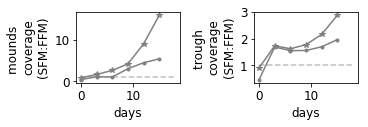

In [39]:
#DIVERGENCE 
var=['mounds','vall']
l=['mounds \ncoverage\n(SFM:FFM)','trough \ncoverage\n(SFM:FFM)']

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5,1.65),constrained_layout=True)
d1=DF[(DF.rep=='I')&(DF.flow=='B1')]
d2=DF[(DF.rep=='II')&(DF.flow=='B1')]
d3=DF[(DF.rep=='I')&(DF.flow=='B5')]
d4=DF[(DF.rep=='II')&(DF.flow=='B5')]
ax=ax.ravel()
for a in range(len(var)):
#     ax[a].plot(,'.-',color=plt.cm.tab10(0),label='FFM Rep I')
    ax[a].plot(d3['time'],d3[var[a]].values/d1[var[a]].values,'.-',color='gray',label='Rep I')
#     ax[a].plot(,'*-',color=plt.cm.tab10(0),label='FFM Rep II')
    ax[a].plot(d4['time'],d4[var[a]].values/d2[var[a]].values,'*-',color='gray',label='Rep II')
    ax[a].set_ylabel(l[a])
    ax[a].hlines(y=1,xmin=0,xmax=18,alpha=.5,color='gray',linestyle='dashed')
ax[-2].set_xlabel('days');
ax[-1].set_xlabel('days');
# ax[-1].legend(prop={'size': 8},bbox_to_anchor=(.95,0.7),
#            bbox_transform=plt.gcf().transFigure)
cm=plt.get_cmap('Oranges',15)
fig.savefig('../plots-figures/FinalFigures/Fig_morphogenesis/panelB2.svg',dpi=300, bbox_inches='tight',transparent=True)

In [27]:
DF[DF.time==15][['mounds','vall','carpet','vol','flow','rep']]

mounds      vall    carpet      vol flow rep
5  0.00737777  0.253225  0.739397  109.355  FFM  II
5    0.126082  0.731433  0.142485  75.0066  SFM  II
5   0.0151349   0.25995  0.724915  107.172  FFM   I
5   0.0876472  0.512593   0.39976  110.536  SFM   I

In [76]:
DF[DF.time==15][['neg_growth_vall','neg_growth_bottom','flow','rep']]

neg_growth_vall  neg_growth_bottom flow rep
5          0.972872           0.381509   B1  II
11         0.991643           0.757046   B5  II
17         0.980119           0.311217   B1   I
23         0.998799           0.358784   B5   I

In [11]:
def Rprops(st):
    Vols=[];Area=[];Hei=[];Asp=[];Times=[];Ori=[];maxis=[];Maxis=[];Ecc=[];
    v=np.stack([valleys(st[t,:,:]) for t in range(st.shape[0])])
    for t in range(st.shape[0]):
        r=regionprops(label(v[t,:,:]==2),intensity_image=st[t,:,:])
        vo=[np.sum(reg.intensity_image)*px_size[0]*px_size[1]*px_size[2] for reg in r]
        h=[reg.max_intensity*px_size[2] for reg in r]
        a=[reg.area*px_size[0]*px_size[1] for reg in r]
        ori=[reg.orientation for reg in r]
        ma=[reg.minor_axis_length*px_size[0] for reg in r]
        Ma=[reg.major_axis_length*px_size[0] for reg in r]
        e=[reg.eccentricity for reg in r]
        
        T=[t for reg in r]
        Ori.extend(ori)
        Vols.extend(vo)
        Hei.extend(h)
        Area.extend(a)
        Asp.extend(h/np.sqrt(a))
        Times.extend(T)
        maxis.extend(ma)
        Maxis.extend(Ma)
        Ecc.extend(e)
    DF=pd.DataFrame({'time':Times,'vols':Vols,'heis':Hei,'areas':Area,'asp':Asp,'orientation':Ori,
                    'maxis':maxis,'Maxis':Maxis,'ecc':Ecc})
    return DF

In [12]:
DF1=pd.DataFrame()
for f in l_files:
    st=imread(f)
    d=Rprops(st)
    d['path']=f
    d['rep']=f.split('Rep')[1].split('_')[0]
    d['flow']=f.split('Rep')[1].split('_')[1]
    DF1=pd.concat([DF1,d],axis=0)
DF1.time=DF1.time*3
DF1=DF1[DF1.time!=18]

/home/depetris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/depetris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/depetris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/depetris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/depetris/anaconda3/lib/python3.6/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DE

In [13]:
DF1['ori1']=((np.pi/2)-DF1.orientation.abs())
DF1['asph']=DF1.Maxis/DF1.maxis
DF1=DF1[DF1.vols/(px_size[0]*px_size[1]*px_size[2])>300]

In [66]:
# DF1.to_csv('../Tables/regionsprops_morphogenesis.csv',index=False)
DF1=pd.read_csv('../Tables/regionsprops_morphogenesis.csv')

/home/depetris/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


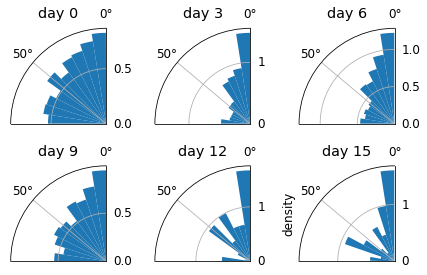

In [15]:
d4=DF1[(DF1.rep=='II')&(DF1.flow=='B5')]
fig=plt.figure(constrained_layout=True)
for t in d4.time.unique():
    ax = plt.subplot(2, 3, list(d4.time.unique()).index(t)+1, projection='polar')
    
    ax.hist(d4[d4.time==t].ori1,bins=10,label=t,density=True);
    ax.set_theta_zero_location("N")
    ax.set_thetamin(0)
    ax.set_thetamax(90)
    ax.set_title('day '+str(t))
# ax.legend(bbox_to_anchor=[1,1])
ax.set_ylabel('density')

plt.tight_layout()
fig.savefig('../plots-figures/20200615/mounds_orientation_SFM_repII.svg',dpi=300)

/home/depetris/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


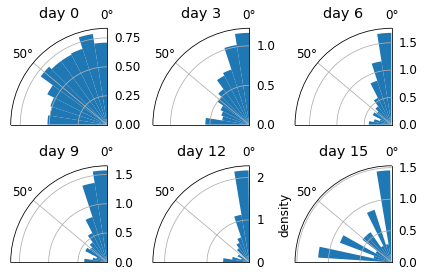

In [16]:
d4=DF1[(DF1.rep=='II')&(DF1.flow=='B1')]
fig=plt.figure(constrained_layout=True)
for t in d4.time.unique():
    ax = plt.subplot(2, 3, list(d4.time.unique()).index(t)+1, projection='polar')
    
    ax.hist(d4[d4.time==t].ori1,bins=10,label=t,density=True);
    ax.set_theta_zero_location("N")
    ax.set_thetamin(0)
    ax.set_thetamax(90)
    ax.set_title('day '+str(t))
# ax.legend(bbox_to_anchor=[1,1])
plt.tight_layout()
ax.set_ylabel('density')

fig.savefig('../plots-figures/20200615/mounds_orientation_FFM_repII.svg',dpi=300)

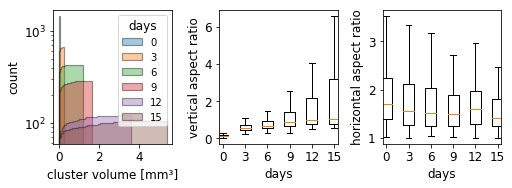

In [99]:
# AGGREGATION
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7,2.5),constrained_layout=True)
ax=ax.ravel()
d3=DF1[(DF1.rep=='I')&(DF1.flow=='B5')]
d4=DF1[(DF1.rep=='II')&(DF1.flow=='B5')]

cma=plt.get_cmap('Oranges_r',18)

for t in d4.time.unique():
    ax[0].hist(d4[d4.time==t].vols,bins=50,histtype='step',cumulative=True,label=t,fill=cma(int(t)),alpha=.4, edgecolor='black', linewidth=1.2)
    ax[0].set_yscale('log')
    ax[0].legend(title='days',fontsize=10)
ax[0].set_ylabel('count')
ax[0].set_xlabel('cluster volume [mm³]')

ax[1].boxplot([d4[d4.time==t].asp for t in d4.time.unique()],positions=d4.time.unique(),
              widths=[1.5 for t in d4.time.unique()],showfliers=False);
ax[1].set_ylabel('vertical aspect ratio')
ax[1].set_xlabel('days')

ax[2].boxplot([d4[d4.time==t].asph for t in d4.time.unique()],positions=d4.time.unique(),
              widths=[1.5 for t in d4.time.unique()],showfliers=False);
ax[2].set_ylabel('horizontal aspect ratio')
ax[2].set_xlabel('days')

fig.savefig('../plots-figures/FinalFigures/Fig_morphogenesis/panelD.svg',dpi=300, bbox_inches='tight',transparent=True)


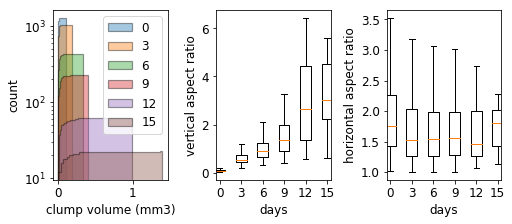

In [423]:
# AGGREGATION
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7,3),constrained_layout=True)
ax=ax.ravel()
d3=DF1[(DF1.rep=='I')&(DF1.flow=='B1')]
d4=DF1[(DF1.rep=='II')&(DF1.flow=='B1')]

cma=plt.get_cmap('Oranges_r',18)

for t in d4.time.unique():
    ax[0].hist(d4[d4.time==t].vols,bins=50,histtype='step',cumulative=True,label=t,fill=cma(int(t)),alpha=.4, edgecolor='black', linewidth=1.2)
    ax[0].set_yscale('log')
    ax[0].legend()
ax[0].set_ylabel('count')
ax[0].set_xlabel('clump volume [mm³]')

ax[1].boxplot([d4[d4.time==t].asp for t in d4.time.unique()],positions=d4.time.unique(),
              widths=[1.5 for t in d4.time.unique()],showfliers=False);
ax[1].set_ylabel('vertical aspect ratio')
ax[1].set_xlabel('days')

ax[2].boxplot([d4[d4.time==t].asph for t in d4.time.unique()],positions=d4.time.unique(),
              widths=[1.5 for t in d4.time.unique()],showfliers=False);
ax[2].set_ylabel('horizontal aspect ratio')
ax[2].set_xlabel('days')

fig.savefig('../plots-figures/20200615/mounds_shape_FFM_repII.svg',dpi=300)


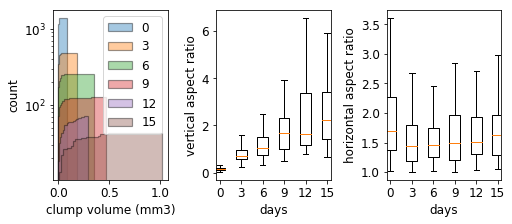

In [428]:
# AGGREGATION
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7,3),constrained_layout=True)
ax=ax.ravel()
d4=DF1[(DF1.rep=='I')&(DF1.flow=='B1')]

cma=plt.get_cmap('Oranges_r',18)

for t in d4.time.unique():
    ax[0].hist(d4[d4.time==t].vols,bins=50,histtype='step',cumulative=True,label=t,fill=cma(int(t)),alpha=.4, edgecolor='black', linewidth=1.2)
    ax[0].set_yscale('log')
    ax[0].legend()
ax[0].set_ylabel('count')
ax[0].set_xlabel('clump volume (mm3)')

ax[1].boxplot([d4[d4.time==t].asp for t in d4.time.unique()],positions=d4.time.unique(),
              widths=[1.5 for t in d4.time.unique()],showfliers=False);
ax[1].set_ylabel('vertical aspect ratio')
ax[1].set_xlabel('days')

ax[2].boxplot([d4[d4.time==t].asph for t in d4.time.unique()],positions=d4.time.unique(),
              widths=[1.5 for t in d4.time.unique()],showfliers=False);
ax[2].set_ylabel('horizontal aspect ratio')
ax[2].set_xlabel('days')

fig.savefig('../plots-figures/20200615/mounds_shape_FFM_repI.svg',dpi=300)


/home/depetris/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/home/depetris/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/home/depetris/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1261: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/home/depetris/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1262: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


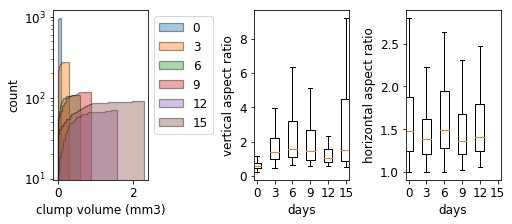

In [432]:
# AGGREGATION
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7,3),constrained_layout=True)
ax=ax.ravel()
d4=DF1[(DF1.rep=='I')&(DF1.flow=='B5')]

cma=plt.get_cmap('Oranges_r',18)

for t in d4.time.unique():
    ax[0].hist(d4[d4.time==t].vols,bins=50,histtype='step',cumulative=True,label=t,fill=cma(int(t)),alpha=.4, edgecolor='black', linewidth=1.2)
    ax[0].set_yscale('log')
    ax[0].legend(bbox_to_anchor=[1,1])
ax[0].set_ylabel('count')
ax[0].set_xlabel('clump volume (mm3)')

ax[1].boxplot([d4[d4.time==t].asp for t in d4.time.unique()],positions=d4.time.unique(),
              widths=[1.5 for t in d4.time.unique()],showfliers=False);
ax[1].set_ylabel('vertical aspect ratio')
ax[1].set_xlabel('days')

ax[2].boxplot([d4[d4.time==t].asph for t in d4.time.unique()],positions=d4.time.unique(),
              widths=[1.5 for t in d4.time.unique()],showfliers=False);
ax[2].set_ylabel('horizontal aspect ratio')
ax[2].set_xlabel('days')

fig.savefig('../plots-figures/20200615/mounds_shape_SFM_repI.svg',dpi=300)


FIGURE 4

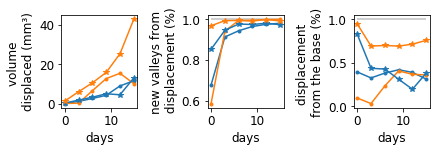

In [67]:
#DYNAMICITY
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(6,2),constrained_layout=True)
d1=DF[(DF.rep=='I')&(DF.flow=='FFM')]
d2=DF[(DF.rep=='II')&(DF.flow=='FFM')]
d3=DF[(DF.rep=='I')&(DF.flow=='SFM')]
d4=DF[(DF.rep=='II')&(DF.flow=='SFM')]
ax=ax.ravel()
ax[0].plot(d1.time,d1.neg_growth,'.-',color=plt.cm.tab10(0),label='FFM Rep I')
ax[0].plot(d3.time,d3.neg_growth,'.-',color=plt.cm.tab10(1),label='SFM Rep I')
ax[0].plot(d2.time,d2.neg_growth,'*-',color=plt.cm.tab10(0),label='FFM Rep II')
ax[0].plot(d4.time,d4.neg_growth,'*-',color=plt.cm.tab10(1),label='SFM Rep II')
ax[0].set_ylabel('volume \ndisplaced (mm³)')
ax[0].set_xlabel('days')

var=['neg_growth_vall', 'neg_growth_bottom']
l=['new valleys from\n displacement (%)','displacement \nfrom the base (%)']

# 'neg_growth_mound',       'neg_growth_carpet','extra_growth_vall', 'extra_growth_carpet',]

for a in range(len(var)):
    ax[a+1].plot(d1.time,d1[var[a]],'.-',color=plt.cm.tab10(0),label='FFM Rep I')
    ax[a+1].plot(d3.time,d3[var[a]],'.-',color=plt.cm.tab10(1),label='SFM Rep I')
    ax[a+1].plot(d2.time,d2[var[a]],'*-',color=plt.cm.tab10(0),label='FFM Rep II')
    ax[a+1].plot(d4.time,d4[var[a]],'*-',color=plt.cm.tab10(1),label='SFM Rep II')
    ax[a+1].set_ylabel(l[a])
    ax[a+1].set_xlabel('days')
    
    ax[a+1].hlines(y=1,xmin=0,xmax=15,alpha=.5,color='gray')
fig.savefig('../plots-figures/FinalFigures/Fig_morphogenesis/panel4A.svg',dpi=300, bbox_inches='tight',transparent=True)


In [ ]:
tr=pd.read_csv('../data-tables/tracking_all.csv')

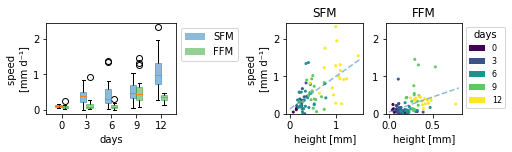

In [41]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7,2),constrained_layout=True, gridspec_kw={'width_ratios': [1.7, 1,1]})
 
s5=[tr.loc[(tr.rep=='II')&(tr.flow==5)&(tr.t0==t),'dist'].values/3 for t in tr.t0.unique()]
s1=[tr.loc[(tr.rep=='II')&(tr.flow==1)&(tr.t0==t),'dist'].values/3 for t in tr.t0.unique()]
w=np.array([.25,.25,.25,.25,.25])
p=np.array([1,2,3,4,5])
c1=plt.cm.tab10(0)
bplot1=ax[0].boxplot(s5,positions=p-w/2,widths=w,patch_artist=True,boxprops=dict(facecolor=c1, color=c1,alpha=.5));
c2=plt.cm.tab10(2)
bplot2=ax[0].boxplot(s1,positions=p+w/2,widths=w,patch_artist=True,boxprops=dict(facecolor=c2, color=c2,alpha=.5));

ax[0].set_xticks(p)
ax[0].set_xticklabels([0,3,6,9,12]);
ax[0].set_ylabel('speed \n[mm d⁻¹]')
ax[0].set_xlabel('days')

legend_elements = [Patch(facecolor=c1,alpha=.5,label='SFM'),
                  Patch(facecolor=c2,alpha=.5,label='FFM')]

ax[0].legend(handles=legend_elements,bbox_to_anchor=[1,1])

e=tr[(tr.rep=='II')]
xnew=np.array([0,1.5])
d=e[e.flow==5]
x=d.hei
y=d.dist/3
reg1=linregress(x,y)
i=ax[1].scatter(d.hei,d.dist/3,c=d.t0.astype('int'),s=4)
ax[1].plot(xnew,reg1[0]*xnew+reg1[1],'--',alpha=.5)

ax[1].set_title('SFM')
ax[1].set_ylim(0,7.3/3)
xnew=np.array([0,.8])
d=e[e.flow==1]
x1=d.hei
y1=d.dist/3
reg2=linregress(x1,y1)
ax[2].scatter(x1,y1,c=d.t0.astype('int'),s=4)
ax[2].plot(xnew,reg2[0]*xnew+reg2[1],'--',alpha=.5)

ax[2].set_title('FFM')
ax[2].set_ylim(0,7.3/3)
ax[1].set_ylabel('speed \n[mm d⁻¹]')
ax[2].set_xlabel('height [mm]')
# plt.colorbar(i)
ax[1].set_xlabel('height [mm]')
cm=plt.get_cmap('viridis',5)
legend_elements = [Patch(facecolor=cm(0),label=0),
                   Patch(facecolor=cm(1),label=3),
                   Patch(facecolor=cm(2),label=6),
                   Patch(facecolor=cm(3),label=9),
                   Patch(facecolor=cm(4),label=12)]

ax[-1].legend(prop={'size': 8},handles=legend_elements,title='days',bbox_to_anchor=[1,1])
#fig.savefig('../plots-figures/FinalFigures/Fig_morphogenesis/panel4B.svg',dpi=300, bbox_inches='tight',transparent=True)


In [42]:
t=[]
for i in range(len(s5)):
    t.append(ttest_ind(s5[i],s1[i]))
pvals=[round(i[1],3) for i in t]
pvals

[0.561, 0.003, 0.001, 0.683, 0.0]

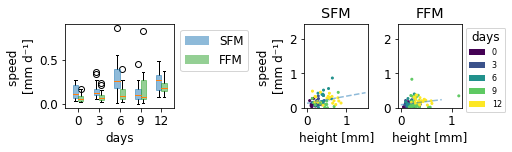

In [37]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7,2),constrained_layout=True, gridspec_kw={'width_ratios': [1.7, 1,1]})
 
s5=[tr.loc[(tr.rep=='I')&(tr.flow==5)&(tr.t0==t),'dist'].values/3 for t in tr.t0.unique()]
s1=[tr.loc[(tr.rep=='I')&(tr.flow==1)&(tr.t0==t),'dist'].values/3 for t in tr.t0.unique()]
w=np.array([.25,.25,.25,.25,.25])
p=np.array([1,2,3,4,5])
c1=plt.cm.tab10(0)
bplot1=ax[0].boxplot(s5,positions=p-w/2,widths=w,patch_artist=True,boxprops=dict(facecolor=c1, color=c1,alpha=.5));
c2=plt.cm.tab10(2)
bplot2=ax[0].boxplot(s1,positions=p+w/2,widths=w,patch_artist=True,boxprops=dict(facecolor=c2, color=c2,alpha=.5));

ax[0].set_xticks(p)
ax[0].set_xticklabels([0,3,6,9,12]);
ax[0].set_ylabel('speed \n[mm d⁻¹]')
ax[0].set_xlabel('days')

legend_elements = [Patch(facecolor=c1,alpha=.5,label='SFM'),
                  Patch(facecolor=c2,alpha=.5,label='FFM')]

ax[0].legend(handles=legend_elements,bbox_to_anchor=[1,1])

e=tr[(tr.rep=='I')]
xnew=np.array([0,1.5])
d=e[e.flow==5]
x=d.hei
y=d.dist/3
reg1=linregress(x,y)
i=ax[1].scatter(d.hei,d.dist/3,c=d.t0.astype('int'),s=4)
ax[1].plot(xnew,reg1[0]*xnew+reg1[1],'--',alpha=.5)

ax[1].set_title('SFM')
ax[1].set_ylim(0,7.3/3)
xnew=np.array([0,.8])
d=e[e.flow==1]
x1=d.hei
y1=d.dist/3
reg2=linregress(x1,y1)
ax[2].scatter(x1,y1,c=d.t0.astype('int'),s=4)
ax[2].plot(xnew,reg2[0]*xnew+reg2[1],'--',alpha=.5)

ax[2].set_title('FFM')
ax[2].set_ylim(0,7.3/3)
ax[1].set_ylabel('speed \n[mm d⁻¹]')
ax[2].set_xlabel('height [mm]')
# plt.colorbar(i)
ax[1].set_xlabel('height [mm]')
cm=plt.get_cmap('viridis',5)
legend_elements = [Patch(facecolor=cm(0),label=0),
                   Patch(facecolor=cm(1),label=3),
                   Patch(facecolor=cm(2),label=6),
                   Patch(facecolor=cm(3),label=9),
                   Patch(facecolor=cm(4),label=12)]

ax[-1].legend(prop={'size': 8},handles=legend_elements,title='days',bbox_to_anchor=[1,1])
#fig.savefig('../plots-figures/FinalFigures/Fig_morphogenesis/SI_Figure_tracking_RepI.svg',dpi=300, bbox_inches='tight',transparent=True)


In [40]:
t=[]
for i in range(len(s5)):
    t.append(ttest_ind(s5[i],s1[i]))
pvals=[round(i[1],3) for i in t]
pvals

[0.017, 0.008, 0.001, 0.64, 0.065]